In [1]:
DATAPATH = '../data/'
XFERPATH = '~/downloads/'  # To transfer files from Google Colab
FNAME = 'embeds_agg.csv'

In [2]:
frompath = XFERPATH + FNAME
topath = DATAPATH + FNAME
!cp $frompath $topath

In [3]:
import keras
import lightgbm as lgb
import pandas as pd
import gender_guesser.detector as gender
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

/home/andy/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
df = pd.read_csv(DATAPATH+FNAME,index_col=[0,1],parse_dates=['time']).drop(['text'],axis=1)
df.head().iloc[:,:7]

,,name,male,embed0,embed1,embed2,embed3,embed4
id,time,,,,,,,
425472153,2019-05-25 20:24:48+00:00,Queen K,False,9156,-31075,-21194,41023,33810
1081873499621273601,2019-05-25 20:24:48+00:00,Alexandru Constantin,True,-34055,62140,-33476,1849,42774
987721418,2019-05-25 20:24:48+00:00,Susie Carmichael,False,-38618,12734,6150,6856,29976
980758839770451973,2019-05-25 20:24:52+00:00,Princess Sih.,False,-19252,-1482,-14205,-25178,-47939
838620336367218692,2019-05-25 20:24:53+00:00,Reid Kisselback,True,-40698,32644,3243,-35412,61766


In [5]:
print(df.shape)
df.index.get_level_values(1).min(), df.index.get_level_values(1).max()

(29678, 514)


(Timestamp('2019-05-21 17:50:48+0000', tz='UTC'),
 Timestamp('2019-05-26 12:53:53+0000', tz='UTC'))

In [6]:
df = df.sort_index(level='time')
df.head().iloc[:,:7]

,,name,male,embed0,embed1,embed2,embed3,embed4
id,time,,,,,,,
211806644,2019-05-21 17:50:48+00:00,Tabitha Rayne,False,36840,45825,-8880,20461,33486
1703564846,2019-05-21 17:50:48+00:00,Dimitri 🖤,True,-42156,32908,-17450,3590,-43536
971515498411241472,2019-05-21 17:50:48+00:00,Paola Vela,False,68532,13781,-52797,555,-125
21947445,2019-05-21 17:50:49+00:00,Nathalie,False,42295,-7144,-4412,-29190,31147
621596924,2019-05-21 17:50:49+00:00,Evan Boland,True,47176,-5129,-26225,-38181,-17701


In [7]:
n_train = int(.6*df.shape[0])
n_val = int(.2*df.shape[0])
n_test = df.shape[0] - n_val - n_train
train_ids = set(df.index.get_level_values(0)[:n_train])
val_ids = set(df.index.get_level_values(0)[n_train:n_train+n_val]) - train_ids
test_ids = set(df.index.get_level_values(0)[n_train+n_val:]) - train_ids - val_ids

In [8]:
len(train_ids), len(val_ids), len(test_ids)

(17403, 5680, 5611)

In [9]:
df_train = df.iloc[:n_train,:].copy()
df_valid = df.iloc[n_train:n_train+n_val,:].copy()
df_test = df.iloc[n_train+n_val:,:].copy()
df_train.shape, df_valid.shape, df_test.shape

((17806, 514), (5935, 514), (5937, 514))

In [10]:
train_select = [v in train_ids for v in df_train.index.get_level_values(0).values.tolist()]
valid_select = [v in val_ids for v in df_valid.index.get_level_values(0).values.tolist()]
test_select = [v in test_ids for v in df_test.index.get_level_values(0).values.tolist()]
df_train = df_train[train_select]
df_valid = df_valid[valid_select]
df_test = df_test[test_select]
df_train.shape, df_valid.shape, df_test.shape

((17806, 514), (5775, 514), (5724, 514))

In [11]:
df_train.index.get_level_values(1).min(), df_train.index.get_level_values(1).max()

(Timestamp('2019-05-21 17:50:48+0000', tz='UTC'),
 Timestamp('2019-05-25 11:55:21+0000', tz='UTC'))

In [12]:
df_valid.index.get_level_values(1).min(), df_valid.index.get_level_values(1).max()

(Timestamp('2019-05-25 11:55:22+0000', tz='UTC'),
 Timestamp('2019-05-26 06:32:23+0000', tz='UTC'))

In [13]:
df_test.index.get_level_values(1)[0], df_test.index.get_level_values(1)[-1]

(Timestamp('2019-05-26 06:32:25+0000', tz='UTC'),
 Timestamp('2019-05-26 12:53:53+0000', tz='UTC'))

In [14]:
ids0 = set(df_train.index.get_level_values(0))
ids1 = set(df_valid.index.get_level_values(0))
ids2 = set(df_test.index.get_level_values(0))
ids0.intersection(ids1), ids1.intersection(ids2), ids0.intersection(ids2)

(set(), set(), set())

In [15]:
n_males_train = df_train.male.sum()
n_females_train = df_train.shape[0] - n_males_train
n_males_train, n_females_train

(11146, 6660)

In [16]:
n_males_valid = df_valid.male.sum()
n_females_valid = df_valid.shape[0] - n_males_valid
n_males_valid, n_females_valid

(3612, 2163)

In [17]:
n_males_test = df_test.male.sum()
n_females_test = df_test.shape[0] - n_males_test
n_males_test, n_females_test

(3643, 2081)

In [18]:
n_each_train = min(n_males_train, n_females_train)
n_each_valid = min(n_males_valid, n_females_valid)
n_each_test = min(n_males_test, n_females_test)
n_each_train, n_each_valid, n_each_test

(6660, 2163, 2081)

In [19]:
df_train_m = df_train[df_train.male].copy().sample(n_each_train)
df_train_f = df_train[~df_train.male].copy().sample(n_each_train)
df_valid_m = df_valid[df_valid.male].copy().sample(n_each_valid)
df_valid_f = df_valid[~df_valid.male].copy().sample(n_each_valid)
df_test_m = df_test[df_test.male].copy().sample(n_each_test)
df_test_f = df_test[~df_test.male].copy().sample(n_each_test)
xy_train = pd.concat([df_train_m, df_train_f]).sample(frac=1)
xy_valid = pd.concat([df_valid_m, df_valid_f]).sample(frac=1)
xy_test = pd.concat([df_test_m, df_test_f]).sample(frac=1)

In [20]:
xy_train.shape, xy_valid.shape, xy_test.shape

((13320, 514), (4326, 514), (4162, 514))

In [21]:
xy_train.male.sum(), xy_valid.male.sum(), xy_test.male.sum()

(6660, 2163, 2081)

In [59]:
xy_train = xy_train.dropna()
xy_valid = xy_valid.dropna()
xy_test = xy_test.dropna()
xy_train.shape, xy_valid.shape, xy_test.shape

((13319, 514), (4326, 514), (4162, 514))

In [60]:
X_train = xy_train.drop(['name','male'],axis=1).values / 1e6
y_train = 1*xy_train.male.values
X_valid = xy_valid.drop(['name','male'],axis=1).values / 1e6
y_valid = 1*xy_valid.male.values
X_test = xy_test.drop(['name','male'],axis=1).values / 1e6
y_test = 1*xy_test.male.values

In [61]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [62]:
X_train.shape

(13319, 512)

In [101]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_dim=512))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(.5))
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dropout(.8))
model.add(keras.layers.Dense(8, activation='relu',))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 64)                32832     
_________________________________________________________________
batch_normalization_15 (Batc (None, 64)                256       
_________________________________________________________________
dense_76 (Dense)             (None, 512)               33280     
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 48)                24624     
_________________________________________________________________
dropout_30 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 8)                 392       
__________

In [102]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train,
          epochs=12,
          batch_size=128,
          validation_data=[X_valid,y_valid])

Train on 13319 samples, validate on 4326 samples
Epoch 1/12
13319/13319 [==============================] - 2s 127us/step - loss: 0.7018 - acc: 0.5063 - val_loss: 0.6904 - val_acc: 0.5411
Epoch 2/12
13319/13319 [==============================] - 0s 37us/step - loss: 0.6816 - acc: 0.5563 - val_loss: 0.6703 - val_acc: 0.5927
Epoch 3/12
13319/13319 [==============================] - 1s 38us/step - loss: 0.6728 - acc: 0.5816 - val_loss: 0.6664 - val_acc: 0.5966
Epoch 4/12
13319/13319 [==============================] - 0s 37us/step - loss: 0.6684 - acc: 0.5889 - val_loss: 0.6651 - val_acc: 0.5918
Epoch 5/12
13319/13319 [==============================] - 1s 38us/step - loss: 0.6652 - acc: 0.5981 - val_loss: 0.6594 - val_acc: 0.6112
Epoch 6/12
13319/13319 [==============================] - 0s 37us/step - loss: 0.6632 - acc: 0.6014 - val_loss: 0.6587 - val_acc: 0.6089
Epoch 7/12
13319/13319 [==============================] - 0s 37us/step - loss: 0.6582 - acc: 0.6018 - val_loss: 0.6592 - val_acc

In [103]:
y_train_pred = model.predict(X_train)
f1_score(y_train, y_train_pred>.5)

0.6533476548514142

In [104]:
y_pred = model.predict(X_valid)
print( confusion_matrix(y_valid, (y_pred>.5)) )
f1_score(y_valid, y_pred>.5)

[[1233  930]
 [ 771 1392]]


0.6207357859531772

In [105]:
y_test_pred = model.predict(X_test)
print( confusion_matrix(y_test, (y_test_pred>.5)) )
f1_score(y_test, y_test_pred>.5)

[[1228  853]
 [ 751 1330]]


0.6238273921200751

In [106]:
accuracy_score(y_test, y_test_pred>.5)

0.6146083613647285

In [107]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

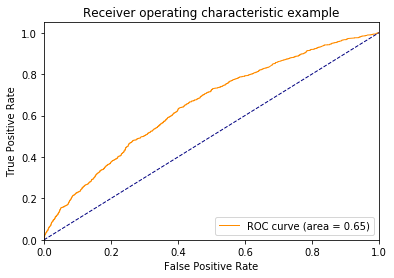

In [108]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()